In [1]:
%load_ext autoreload
%autoreload 2

# Base Notebook to re-create figures of _

This notebook is the base notebook for 10X's Xenium brain showcase tissue sample. It runs the standard ovrlpy pipeline and saves the results to be used in further analysis.

In [1]:
from pathlib import Path
import matplotlib

centimeter = 1/2.54 # conversion from inch, for plotting

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 6}

matplotlib.rc('font', **font)

data_folder_path = Path("/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/Xenium-brain-2024/replicate1")


### Data loader:

In [2]:
import pandas as  pd

coordinate_df = pd.read_parquet(data_folder_path/"transcripts.parquet")
coordinate_df["feature_name"]=coordinate_df.feature_name.str.decode("utf-8")

# remove dummy molecules:
dummy_mask = (coordinate_df.feature_name.str.contains('BLANK') | coordinate_df.feature_name.str.contains('NegControl'))
coordinate_df = coordinate_df[~dummy_mask]

# format columns:
coordinate_df = coordinate_df[['x_location','y_location','z_location','feature_name','cell_id','overlaps_nucleus','qv']]
coordinate_df.columns = ['x','y','z','gene','cell_id','overlaps_nucleus','qv']
coordinate_df['gene'] = coordinate_df['gene'].astype("category")

print(f"Number of cells: {coordinate_df.cell_id.nunique()}",f"Number of genes: {coordinate_df.gene.nunique()}",f"Number of molecules: {coordinate_df.shape[0]}",sep="\n")

Number of cells: 162034
Number of genes: 248
Number of molecules: 62384369


### Run the basic ovrlppy pipeline:

We expect a roughly estimated 30 cell types in the sample. For the remaining parameters, we use the default values.

In [3]:
# import ovrlpy

# signal_integrity, signal_strength,visualizer = ovrlpy.run(coordinate_df, n_expected_celltypes=30)

# visualizer.plot_fit()

# # visualizer.save("./publication/xenium-brain/xenium-brain.vis")

In [4]:
import ovrlpy

ovrlpy.pre_process_coordinates(coordinate_df)

visualizer = ovrlpy.load_visualizer("./publication/xenium-brain/xenium-brain.vis")

signal_integrity, signal_strength = visualizer.integrity_map, visualizer.signal_map

### UMAP annotation using external gene expression signatures:

We can use external gene expression signatures to annotate the UMAP. In this case, we use cell features extracted from the allen brain atlas (REF):

/tmp/ipykernel_2570318/2917016521.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


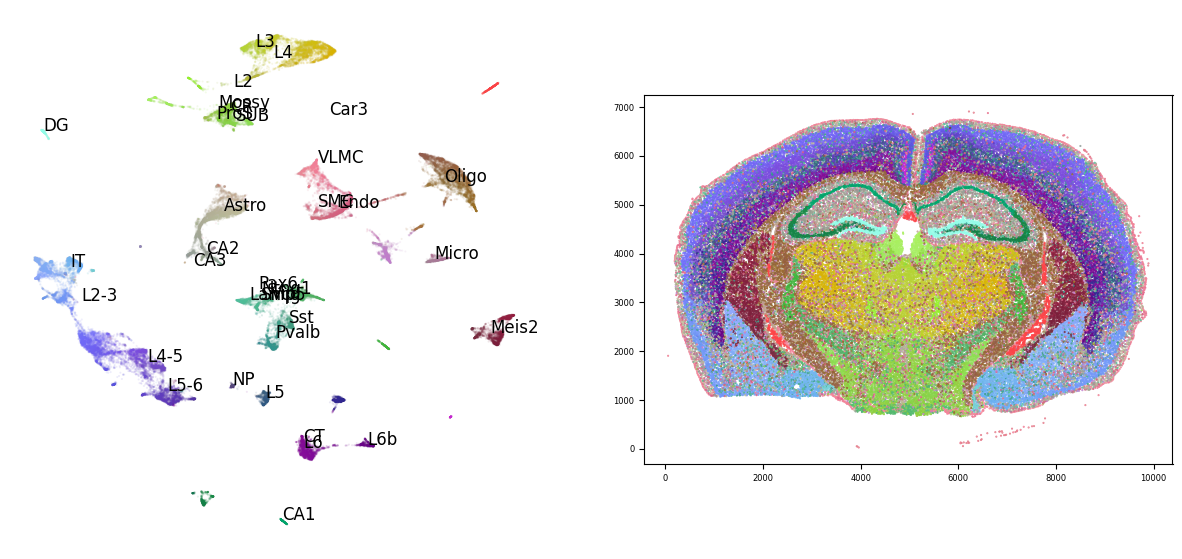

In [5]:
import numpy as np
import matplotlib.pyplot as plt

signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=visualizer.genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in visualizer.genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 

signatures.columns=signatures.columns.str.replace('/','-')

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

# plt.savefig("./manuscript/figures/results/xenium-brain/ct_fit.svg")

In [ ]:
cm = 1/2.54  # centimeters in inches


xlims = [[2849-50, 2849+50],
       [6700+40, 7000+40],
       [3800, 4100],]
ylims = [[2315-50, 2315+50],
       [5000-70, 5300-70],
       [ 710, 1010],]

fig, ax = ovrlpy.plot_signal_integrity(
    signal_integrity, signal_strength, signal_threshold=3, figure_height=9*cm
)
for i in range(3):
    ax[0].add_artist(plt.Rectangle((xlims[i][0],ylims[i][0]),xlims[i][1]-xlims[i][0],ylims[i][1]-ylims[i][0],fill=None,edgecolor='w',lw=2))
    # txt = plt.text(xlims[i][0]-10,ylims[i][1],f'{i+1}',color='w',fontsize=20,ha='right',va='top')

# plt.savefig('./publication/xenium-brain/figures/xenium_integrity_with_highlights.svg',dpi=600)
# plt.savefig('./publication/xenium-brain/figures/xenium_integrity_with_highlights.pdf',dpi=600)

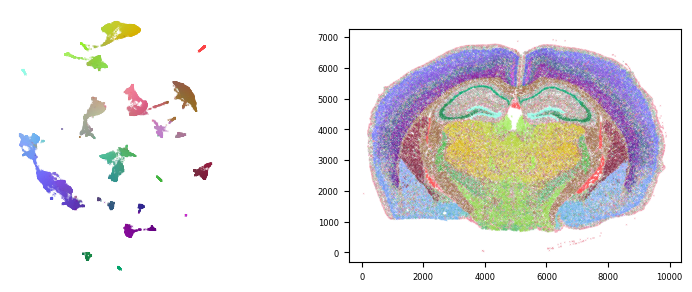

In [7]:
plt.figure(figsize=(24*centimeter, 9*centimeter))

ax1 = plt.subplot(121)
plt.scatter(visualizer.embedding[:, 0], visualizer.embedding[:, 1], marker='x',s=0.01, c=visualizer.colors,rasterized=True)
plt.axis("off")
ax1.set_aspect("equal")

ax2 = plt.subplot(122)
plt.scatter(visualizer.pseudocell_locations_x, visualizer.pseudocell_locations_y, marker='x', s=0.01, c=visualizer.colors,rasterized=True)

ax2.set_aspect("equal")

plt.savefig("./publication/xenium-brain/xenium-brain.pdf", dpi=600)
plt.savefig("./publication/xenium-brain/xenium-brain.svg", dpi=600)

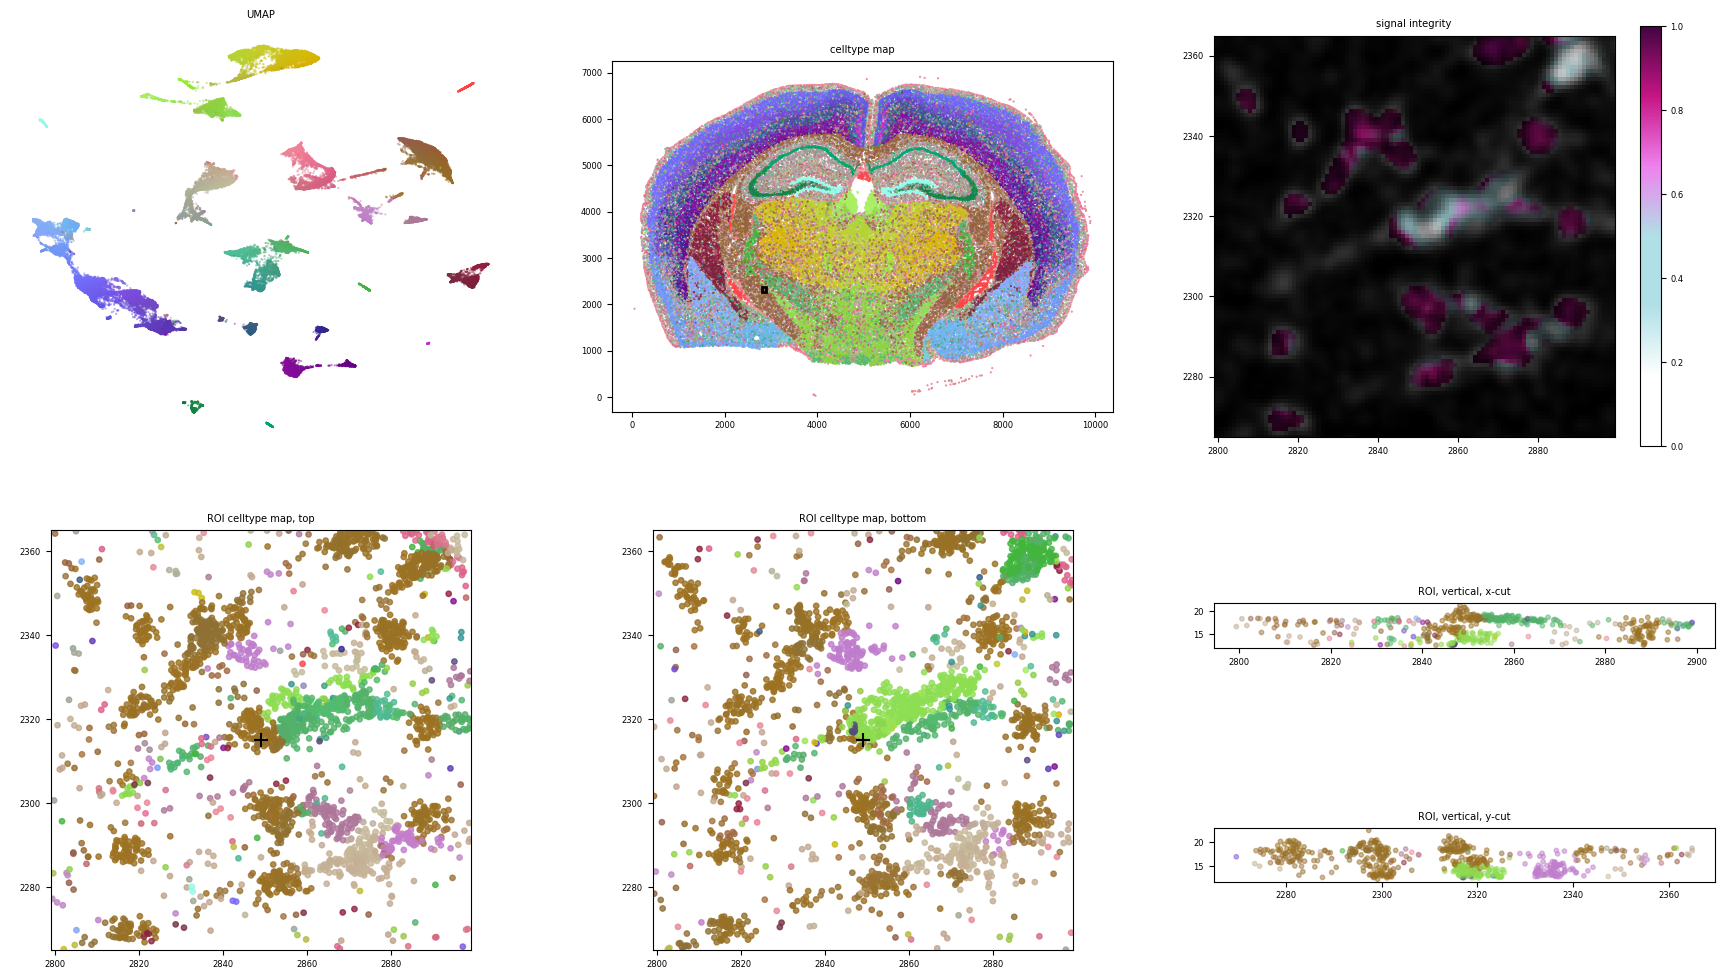

In [13]:
xs = [2849,6900,4100]
ys = [2315,5080,945]

for i in range(len(xs)):

    ovrlpy.plot_region_of_interest(xs[i],
                                   ys[i],
                                   coordinate_df,
                                   visualizer,
                                   signal_integrity,
                                   signal_strength,
                                   window_size=50,
                                   )
    
    
    plt.savefig(f'./publication/xenium-brain/figures/xenium_highlight_map_{i+1}.svg',dpi=600)
    plt.savefig(f'./publication/xenium-brain/figures/xenium_highlight_map_{i+1}.pdf',dpi=600)
    
    break

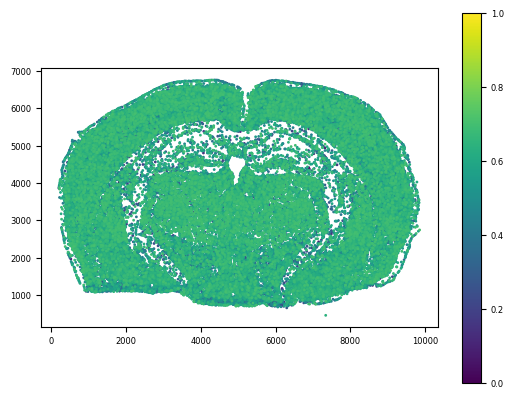

In [10]:
doublet_df = ovrlpy.detect_doublets(
    signal_integrity, signal_strength, minimum_signal_strength=3, integrity_sigma=2
)

_ = plt.scatter(
    doublet_df["x"],
    doublet_df["y"],
    c=doublet_df["integrity"],
    s=1,
    cmap="viridis",
    vmin=0,
    vmax=1,
)
plt.gca().set_aspect("equal")
plt.colorbar()

In [11]:
window_size = 40

for doublet_case in range(20):
    x, y = doublet_df.loc[doublet_case, ["x", "y"]]
    
    ovrlpy.plot_region_of_interest(
        x,
        y,
        coordinate_df,
        visualizer,
        signal_integrity,
        signal_strength,
        window_size=window_size,
    )
    
    # plt.gcf().set_size_inches(32*cm,16*cm)
    
    plt.savefig(f'./publication/xenium-brain/figures/doublet-case-visualizations/xenium_doublet_case_{doublet_case+1}.svg',dpi=600)
    
    plt.close()
    # break

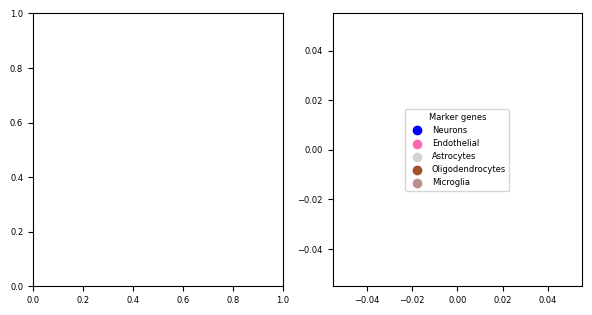

In [13]:
gene_group_df = pd.read_csv(data_folder_path/"Xenium_V1_FF_Mouse_Brain_MultiSection_Input_gene_groups.csv",header=0,index_col=0,usecols=[0,1])
gene_group_df

gene_group_df.group.value_counts()


marker_color_dict = {'Neurons': 'blue',
                     'Endothelial': 'hotpink',
                     'Astrocytes': 'lightgrey',
                        'Oligodendrocytes': 'sienna',
                        'Microglia': 'rosybrown',}

fig,axes = plt.subplots(1,2,figsize=(18*centimeter,9*centimeter))

axes[1].legend([plt.scatter([],[],c=color,label=label) for label,color in marker_color_dict.items()],marker_color_dict.keys(),loc='center',title='Marker genes')


In [14]:

neuron_colors = ['lime','mediumslateblue','lime','mediumslateblue','lime','darkred','khaki','cornflowerblue','green','mediumslateblue',]

for i in range(len(neuron_colors)):
    
    x,y = doublet_df.loc[i,['x','y']]
        
    subsample = visualizer.subsample_df(x,y,coordinate_df=coordinate_df,window_size=50)
    
    subsample_embedding,subsample_rgb = visualizer.transform_transcripts(subsample)
    
    subsample_z_order = subsample.z.argsort()
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(141)
    plt.scatter(x=subsample.x.iloc[subsample_z_order],y=subsample.y.iloc[subsample_z_order],c=subsample_rgb[subsample_z_order],s=1,rasterized=True)
    plt.gca().set_aspect('equal')
    plt.plot([x,x+10],[y,y],c='k',lw=5)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(142)
    plt.scatter(x=subsample.x.iloc[subsample_z_order[::-1]],y=subsample.y.iloc[subsample_z_order[::-1]],c=subsample_rgb[subsample_z_order[::-1]],s=1,rasterized=True)
    plt.gca().set_aspect('equal')   
    plt.xticks([])
    plt.yticks([])
    
    ax3 = plt.subplot(143)
    ax4 = plt.subplot(144)
    
    marker_color_dict['Neurons'] = neuron_colors[i] 
    
    for j, marker_type in enumerate(marker_color_dict.keys()):
        subset_marker_df = subsample[subsample.gene.isin(gene_group_df[gene_group_df.group==marker_type].index)]
        subset_marker_df[subset_marker_df.z>subset_marker_df.z_delim].plot.scatter('x','y',color=marker_color_dict[marker_type],s=2,ax=ax3,rasterized=True)
        subset_marker_df[subset_marker_df.z<subset_marker_df.z_delim].plot.scatter('x','y',color=marker_color_dict[marker_type],s=2,ax=ax4,rasterized=True)
        
    ax3.set_aspect('equal')
    ax4.set_aspect('equal')
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4.set_xticks([])
    ax4.set_yticks([])
    
    plt.savefig(f'./publication/xenium-brain/figures/doublet-case-visualizations/xenium_doublet_case_markers_{i+1}.svg',dpi=600)
        

KeyboardInterrupt: 

In [15]:
adata

NameError: name 'adata' is not defined